In [17]:
import cv2
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns 
import clahe

# Load ResNet50 model for feature extraction
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50, preprocess_input

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

import tensorflow as tf

# from sklearn_relief import ReliefF 
from skrebate import ReliefF
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.ensemble import VotingClassifier

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

In [27]:
def load_yolo():
    path_to_cfg = "/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/yolo/yolov3.cfg" 
    path_to_weights = "/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/yolo/yolov3.weights"
    net = cv2.dnn.readNet(path_to_weights, path_to_cfg)
    layers_names = net.getLayerNames()
    
    # Handling different versions of OpenCV which may return different formats
    try:
        output_layers = [layers_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    except Exception:
        output_layers = [layers_names[i - 1] for i in net.getUnconnectedOutLayers()]

    return net, output_layers

def yolo_detect(net, image, output_layers, confidence_threshold=0.3):
    height, width, _ = image.shape
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(output_layers)
    boxes = []
    confidences = []

    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > confidence_threshold and class_id == 0:  # Person class
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                if x >= 0 and y >= 0 and (x + w) <= width and (y + h) <= height:
                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))

    # Select the largest vertical box based on area if any boxes were detected
    if boxes:
        largest_box = max(boxes, key=lambda b: b[2] * b[3])  # b[2]*b[3] is the area of the box (w*h)
        largest_confidence = confidences[boxes.index(largest_box)]
        return [largest_box], [largest_confidence]
    return [], []  # Return empty lists if no boxes detected


In [27]:
# def extract_features(images):
#     # Load ResNet50 model
#     resnet_model = ResNet50(include_top=False, weights='imagenet', pooling='avg')
#     processed_images = []

#     for img in images:
#         if img is not None and img.size > 0:  # Ensure the image is not empty
#             resized_img = cv2.resize(img, (224, 224))
#             processed_images.append(resized_img)
    
#     if not processed_images:
#         return np.array([])  # Return empty array if no images to process
    
#     images_array = np.array(processed_images)
#     images_array = preprocess_input(images_array)
#     features = resnet_model.predict(images_array)
    
#     return features


In [19]:
import numpy as np
import cv2
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2



# ResNet50 model without the classification layer
def load_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    
    x = GlobalAveragePooling2D()(x)
    # x = Dense(256, activation='relu')(x)  # Adding L2 regularization
    # x = Dropout(0.3)(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

def extract_features(images, model):
    processed_images = []

    for img in images:
        if img is not None and img.size > 0:  # to ensure the image is not empty
            resized_img = cv2.resize(img, (224, 224))
            processed_images.append(resized_img)
    
    if not processed_images:
        return np.array([])  # return empty array if no images to process
    
    images_array = np.array(processed_images)
    images_array = preprocess_input(images_array)
    features = model.predict(images_array)
    
    return features

    # features = features.reshape((features.shape[0], -1))
    



In [20]:
# Create an instance of CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

def load_and_preprocess_data(root_folder, net, output_layers,model):
    images = []
    labels = []
    valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")
    
    for player_name in os.listdir(root_folder):
        player_folder = os.path.join(root_folder, player_name)
        if os.path.isdir(player_folder):
            for img_file in os.listdir(player_folder):
                if img_file.lower().endswith(valid_extensions):
                    img_path = os.path.join(player_folder, img_file)
                    img = cv2.imread(img_path)
                    if img is None or img.size == 0:
                        print(f"Failed to load image {img_path}.")
                        continue

                    boxes, _ = yolo_detect(net, img, output_layers)

                    for box in boxes:
                        x, y, w, h = box
                        if w > 0 and h > 0:  # Check if box dimensions are valid
                            cropped_img = img[y:y+h, x:x+w]

                            # # Apply CLAHE
                            # lab = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2LAB)
                            # l, a, b = cv2.split(lab)
                            # l = clahe.apply(l)
                            # processed_img = cv2.merge([l, a, b])
                            # processed_img = cv2.cvtColor(processed_img, cv2.COLOR_LAB2BGR)

                            if cropped_img.size > 0:  # Check if the cropped image is not empty
                                images.append(cropped_img)
                                labels.append(player_name)

    if not images:
        print("No valid images found in dataset.")
        return np.array([]), np.array([]), None  # Return empty arrays if no images
    
    # Extract features using the pre-trained model
    features = extract_features(images,model)
    
    if features.size == 0:
        print("No features extracted.")
        return np.array([]), np.array([]), None  # Return empty arrays if no features extracted
    
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)
    
    return features, encoded_labels, encoder

In [21]:
def plot_learning_curves(model, X, y, title='Learning Curves'):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10), scoring='accuracy')

    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, 'o-', color="r",  label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

    # Draw bands for standard deviation
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy Score")
    plt.legend(loc="best")
    plt.show()

In [22]:
def plot_features(X_transformed, y, encoder, title):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(scatter, ticks=range(len(encoder.classes_)), label='Classes')
    plt.clim(-0.5, len(encoder.classes_)-0.5)
    plt.grid(True)
    plt.show()

def visualize_with_pca(X, y, encoder, title='PCA Visualization'):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    plot_features(X_pca, y, encoder, title)

def visualize_with_tsne(X, y, encoder, title='t-SNE Visualization'):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200, n_iter=300)
    X_tsne = tsne.fit_transform(X)
    plot_features(X_tsne, y, encoder, title)

# SVM

In [25]:
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_with_pca_plotly(X, y, encoder, title='3D PCA Visualization'):
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)
    plot_features_3d_plotly(X_pca, y, encoder, title)

def visualize_with_tsne_plotly(X, y, encoder, title='3D t-SNE Visualization'):
    tsne = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=300)
    X_tsne = tsne.fit_transform(X)
    plot_features_3d_plotly(X_tsne, y, encoder, title)

def plot_features_3d_plotly(X_transformed, y, encoder, title):
    fig = px.scatter_3d(
        x=X_transformed[:, 0], y=X_transformed[:, 1], z=X_transformed[:, 2],
        color=encoder.inverse_transform(y),  # Use inverse_transform to get original labels
        labels={'color': 'Classes'},
        title=title
    )
    fig.update_traces(marker=dict(size=5, line=dict(width=2, color='DarkSlateGrey')))
    fig.update_layout(legend_title_text='Class')
    fig.show()

26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step


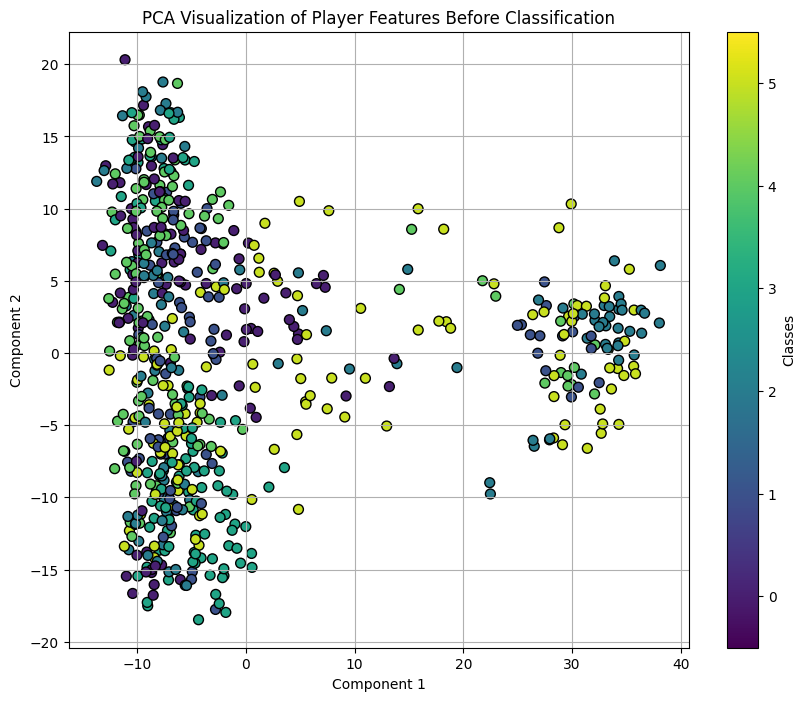

/Users/nadunsenarathne/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


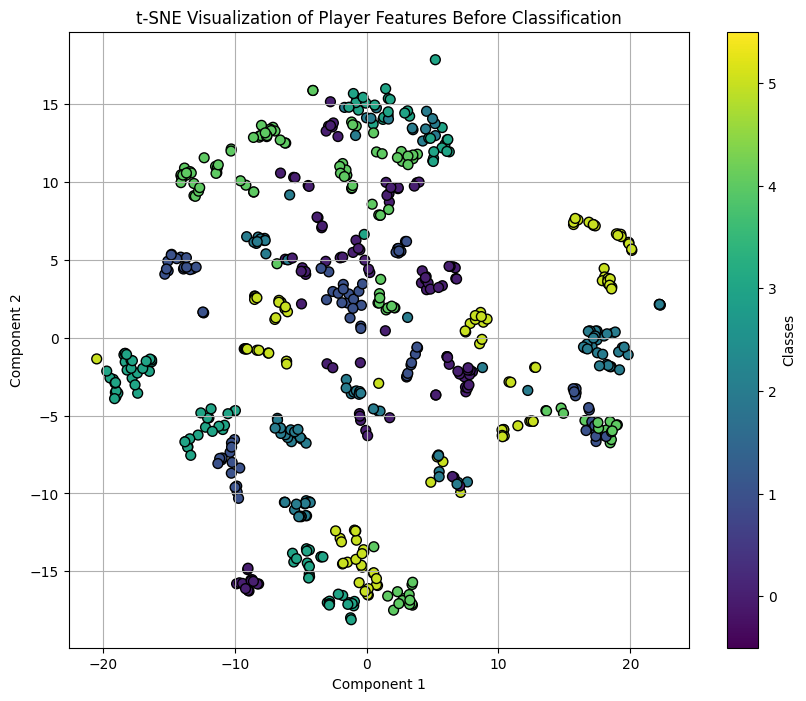

Training Accuracy: 0.9675425038639877
Testing Accuracy: 0.9320987654320988


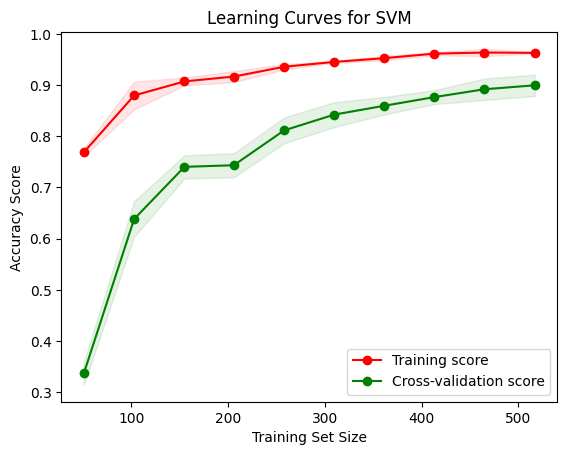

Classification Report:
                 precision    recall  f1-score   support

 Arshdeep_Singh       0.94      1.00      0.97        29
     Axar_Patel       0.89      0.89      0.89        19
 Jasprit_Bumrah       1.00      0.82      0.90        28
  Kuldeep_Yadav       0.87      1.00      0.93        33
Ravindra_Jadeja       0.96      0.85      0.90        26
    Virat_Kohli       0.96      1.00      0.98        27

       accuracy                           0.93       162
      macro avg       0.94      0.93      0.93       162
   weighted avg       0.94      0.93      0.93       162



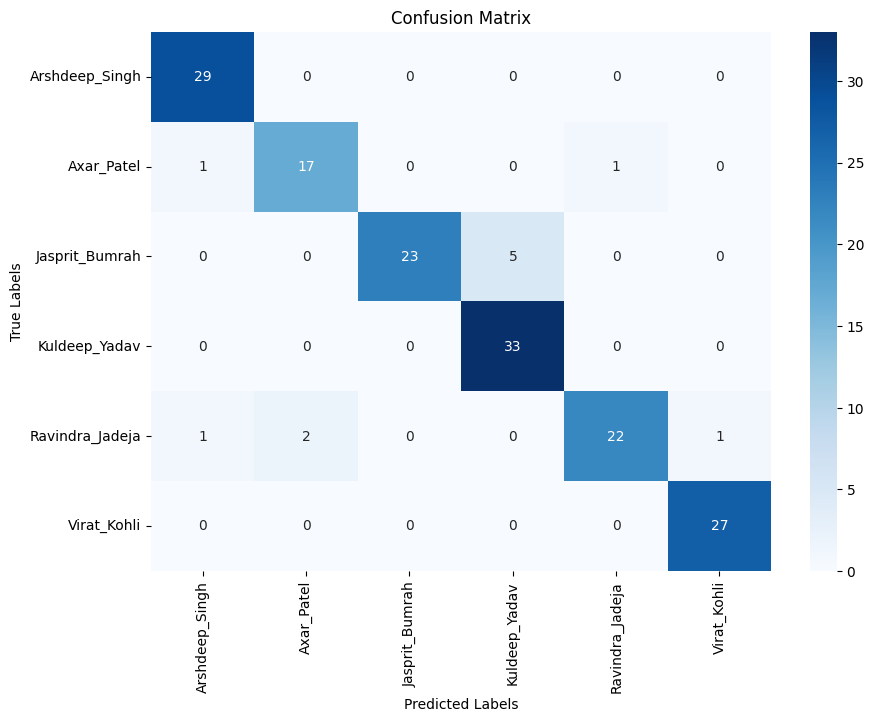

In [28]:
def main():
    # Load YOLO model for detection
    net, output_layers = load_yolo()

    # Load the ResNet model for feature extraction
    model = load_model()
    
    output_frame_folder = '/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/extracted_frames'
    

    # Load and preprocess data, passing the model for feature extraction
    X, y, encoder = load_and_preprocess_data(output_frame_folder, net, output_layers,model)

    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # print('X_train : ',X_train)
    # print(X_train.shape)
    # print('\n y_train : ',y_train)
    # print(y_train.shape)

    # Visualization before classification
    visualize_with_pca(X_train, y_train, encoder, 'PCA Visualization of Player Features Before Classification')
    visualize_with_tsne(X_train, y_train, encoder, 't-SNE Visualization of Player Features Before Classification')

    # # Visualize training data in 3D using PCA
    # visualize_with_pca_plotly(X_train, y_train, encoder, 'Interactive 3D PCA Visualization of Training Data')
    # # Visualize training data in 3D using t-SNE
    # visualize_with_tsne_plotly(X_train, y_train, encoder, 'Interactive 3D t-SNE Visualization of Training Data')

    # Train SVM
    svm_classifier = SVC(C= 1, gamma= 'scale', kernel= 'rbf', probability=True)
    svm_classifier.fit(X_train, y_train)

    # Evaluate the classifier
    train_accuracy = svm_classifier.score(X_train, y_train)
    test_accuracy = svm_classifier.score(X_test, y_test)
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Testing Accuracy: {test_accuracy}")

    # Plotting the learning curves for the ensemble model
    plot_learning_curves(svm_classifier, X_train, y_train, title='Learning Curves for SVM')

    # Generate classification report
    y_pred = svm_classifier.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=encoder.classes_)
    print("Classification Report:")
    print(report)

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Save the SVM model and label encoder
    # joblib.dump(svm_classifier, 'svm_player_recognition.pkl')
    # joblib.dump(encoder, 'svm_label_encoder.pkl')

if __name__ == "__main__":
    main()

##### with learning curve and cross validation

26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 651ms/step
Training Accuracy: 1.0
Testing Accuracy: 0.9337349397590361
Cross-validation scores: [0.80120482 0.87878788 0.87878788 0.84848485 0.82424242]
Mean cross-validation score: 0.8463015699160277


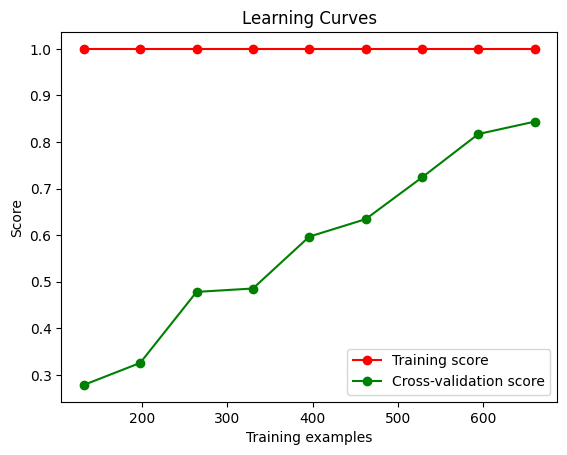

Classification Report:
                 precision    recall  f1-score   support

 Arshdeep_Singh       0.88      0.97      0.92        30
     Axar_Patel       0.93      0.89      0.91        28
 Jasprit_Bumrah       0.96      0.90      0.93        30
  Kuldeep_Yadav       0.97      0.97      0.97        31
Ravindra_Jadeja       0.91      0.88      0.89        24
    Virat_Kohli       0.96      1.00      0.98        23

       accuracy                           0.93       166
      macro avg       0.93      0.93      0.93       166
   weighted avg       0.93      0.93      0.93       166



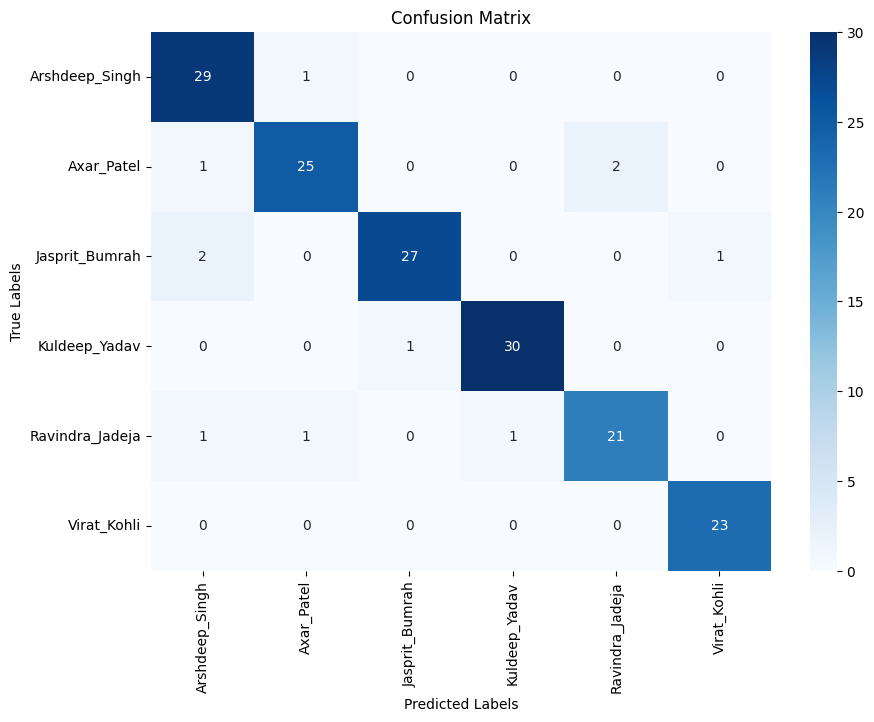

In [63]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import numpy as np

def main():
    # Load YOLO model for detection
    net, output_layers = load_yolo()

    # Load the ResNet model for feature extraction
    model = load_model()
    
    output_frame_folder = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/extracted_frames'
    
    # Load and preprocess data, passing the model for feature extraction
    X, y, encoder = load_and_preprocess_data(output_frame_folder, net, output_layers, model)

    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train SVM
    svm_classifier = SVC(kernel='linear', probability=True)
    svm_classifier.fit(X_train, y_train)

    # Evaluate the classifier
    train_accuracy = svm_classifier.score(X_train, y_train)
    test_accuracy = svm_classifier.score(X_test, y_test)
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Testing Accuracy: {test_accuracy}")

    # Cross-validation
    cv_scores = cross_val_score(svm_classifier, X, y, cv=5)
    print("Cross-validation scores:", cv_scores)
    print("Mean cross-validation score:", cv_scores.mean())

    # Learning Curves
    train_sizes, train_scores, test_scores = learning_curve(
        svm_classifier, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(.1, 1.0, 10))
    
    plot_learning_curves(train_sizes, train_scores, test_scores)

    # Generate classification report
    y_pred = svm_classifier.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=encoder.classes_)
    print("Classification Report:")
    print(report)

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Save the SVM model and label encoder
    joblib.dump(svm_classifier, 'svm_player_recognition.pkl')
    joblib.dump(encoder, 'svm_label_encoder.pkl')

def plot_learning_curves(train_sizes, train_scores, test_scores):
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.title("Learning Curves")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.show()

if __name__ == "__main__":
    main()


##### with learning curve and hyperparameter tuning

26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 665ms/step
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.95
Training Accuracy: 1.0
Testing Accuracy: 0.9939759036144579


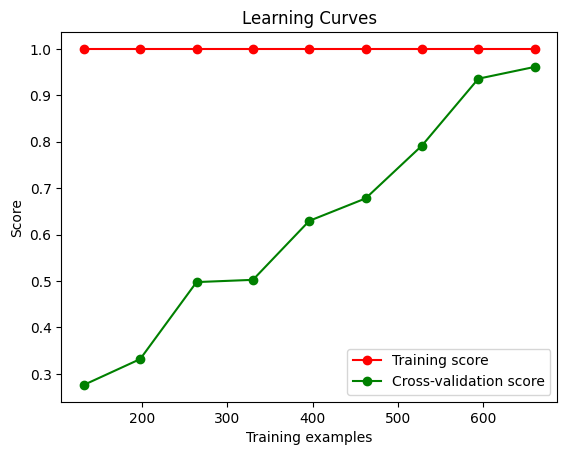

Classification Report:
                 precision    recall  f1-score   support

 Arshdeep_Singh       0.97      1.00      0.98        30
     Axar_Patel       1.00      1.00      1.00        28
 Jasprit_Bumrah       1.00      0.97      0.98        30
  Kuldeep_Yadav       1.00      1.00      1.00        31
Ravindra_Jadeja       1.00      1.00      1.00        24
    Virat_Kohli       1.00      1.00      1.00        23

       accuracy                           0.99       166
      macro avg       0.99      0.99      0.99       166
   weighted avg       0.99      0.99      0.99       166



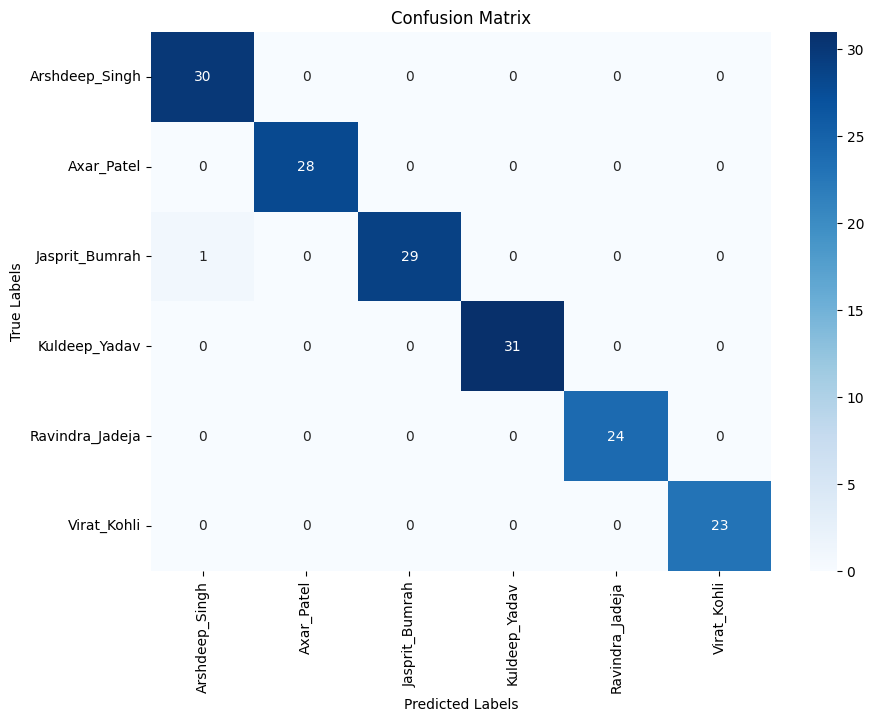

In [67]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import numpy as np

def main():
    # Load YOLO model for detection
    net, output_layers = load_yolo()

    # Load the ResNet model for feature extraction
    model = load_model()
    
    output_frame_folder = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/extracted_frames'
    
    # Load and preprocess data, passing the model for feature extraction
    X, y, encoder = load_and_preprocess_data(output_frame_folder, net, output_layers, model)

    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Set up the parameter grid
    param_grid = {
        'C': [0.1, 1, 10, 100],  # Regularization parameter
        'kernel': ['linear', 'rbf'],  # Type of kernel
        'gamma': ['scale', 'auto']  # Kernel coefficient
    }

    # Create an SVC classifier object
    svm = SVC(probability=True)

    # Create a GridSearchCV object
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', verbose=1)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    # Print out the best parameters and best score
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

    # Retrieve the best model from the grid search
    best_svm = grid_search.best_estimator_
    
    # Evaluate the best model on the training set
    training_accuracy = best_svm.score(X_train, y_train)
    print(f"Training Accuracy: {training_accuracy}")

    # Evaluate the best model on the test set
    test_accuracy = best_svm.score(X_test, y_test)
    print(f"Testing Accuracy: {test_accuracy}")

    # Learning Curves
    train_sizes, train_scores, test_scores = learning_curve(
        best_svm, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(.1, 1.0, 10))
    
    plot_learning_curves(train_sizes, train_scores, test_scores)

    # Generate classification report
    y_pred = best_svm.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=encoder.classes_)
    print("Classification Report:")
    print(report)

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Save the best SVM model and label encoder
    joblib.dump(best_svm, 'best_svm_player_recognition.pkl')
    joblib.dump(encoder, 'svm_label_encoder.pkl')

def plot_learning_curves(train_sizes, train_scores, test_scores):
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.title("Learning Curves")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.show()

if __name__ == "__main__":
    main()


# KNN

26/26 ━━━━━━━━━━━━━━━━━━━━ 26s 976ms/step


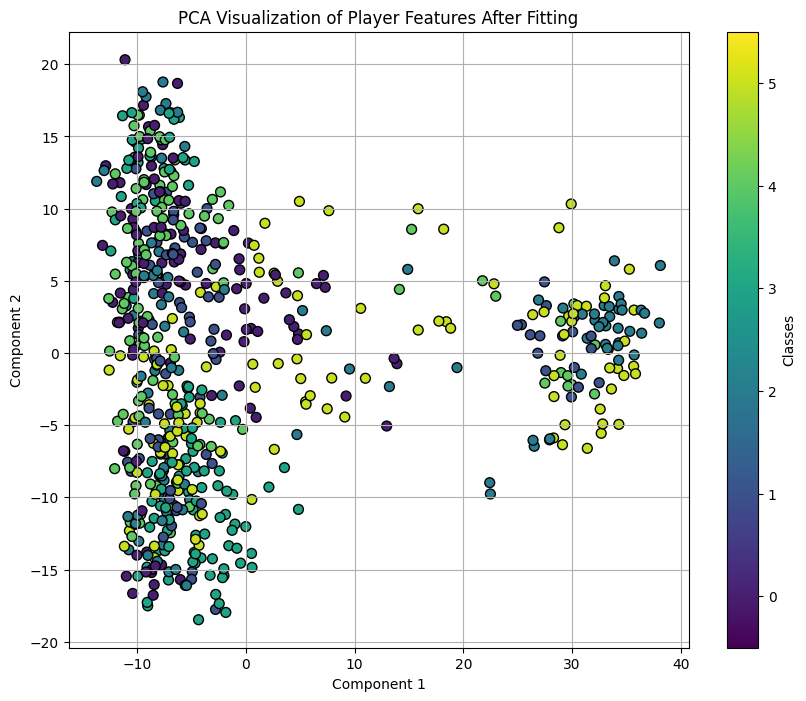

/Users/nadunsenarathne/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


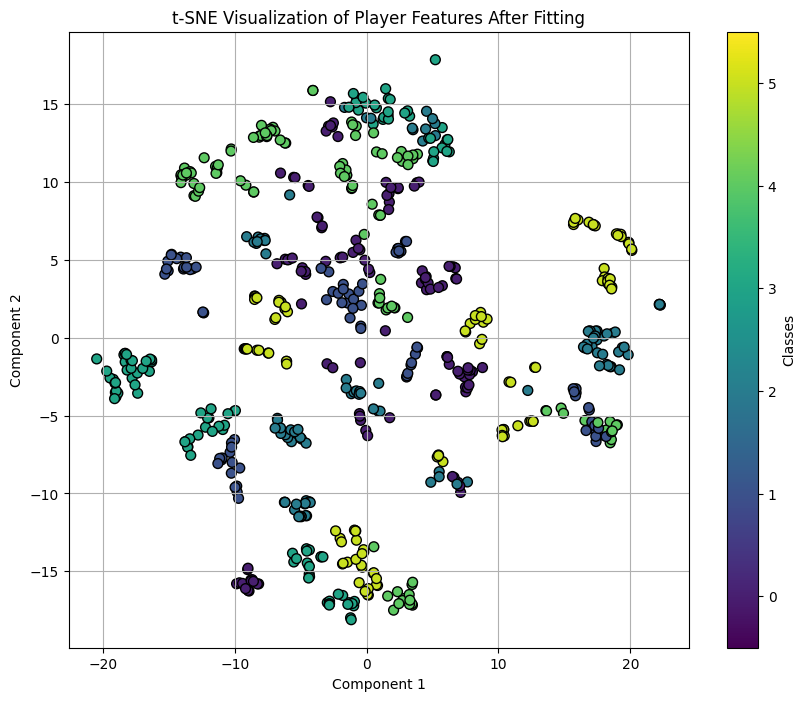

Training Accuracy: 0.9721792890262752
Testing Accuracy: 0.9814814814814815


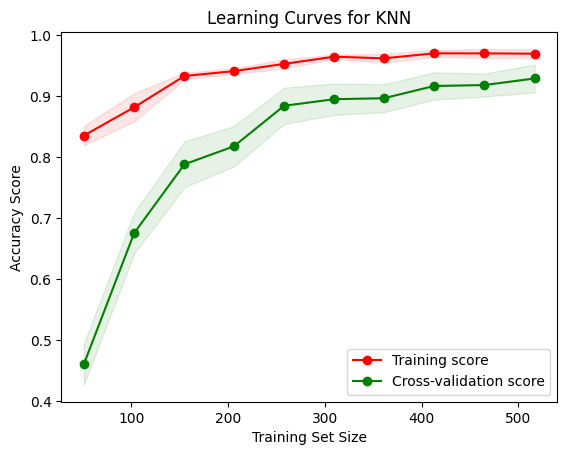

Classification Report:
                 precision    recall  f1-score   support

 Arshdeep_Singh       0.97      0.97      0.97        29
     Axar_Patel       0.95      0.95      0.95        19
 Jasprit_Bumrah       1.00      1.00      1.00        28
  Kuldeep_Yadav       1.00      1.00      1.00        33
Ravindra_Jadeja       1.00      0.96      0.98        26
    Virat_Kohli       0.96      1.00      0.98        27

       accuracy                           0.98       162
      macro avg       0.98      0.98      0.98       162
   weighted avg       0.98      0.98      0.98       162



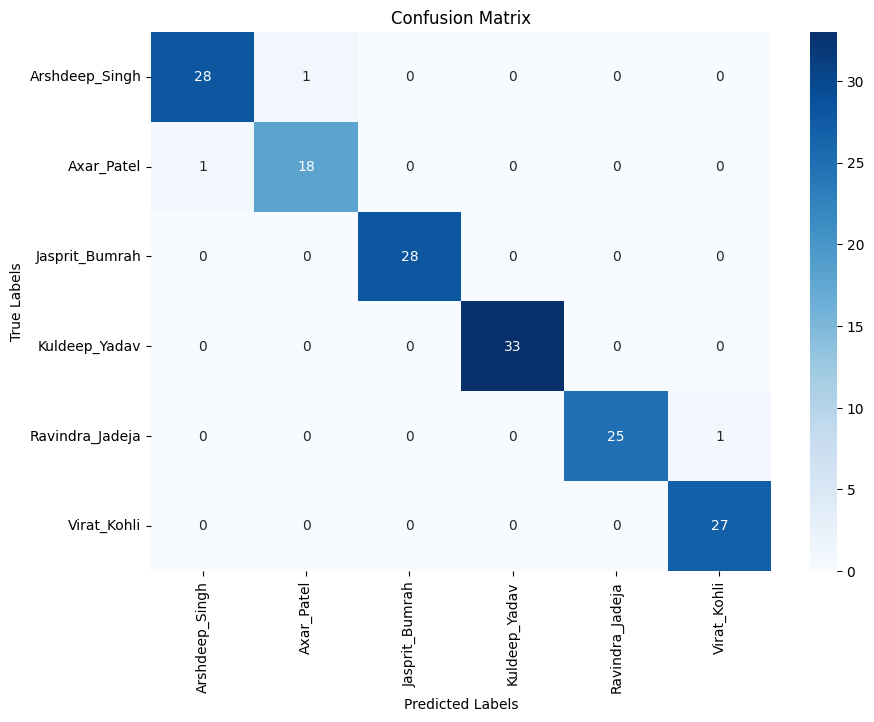

In [29]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

def main():
    # Load YOLO model for detection
    net, output_layers = load_yolo()

    # Load the ResNet model for feature extraction
    model = load_model()
    
    output_frame_folder = '/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/extracted_frames'
    
    # Load and preprocess data, now passing the model for feature extraction
    X, y, encoder = load_and_preprocess_data(output_frame_folder, net, output_layers, model)

    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train KNN
    knn_classifier = KNeighborsClassifier(n_neighbors=3,metric= 'manhattan', weights= 'uniform')
    knn_classifier.fit(X_train, y_train)

    # Make predictions on the training data
    y_pred_train = knn_classifier.predict(X_train)
    # Visualization after fitting
    visualize_with_pca(X_train, y_pred_train, encoder, 'PCA Visualization of Player Features After Fitting')
    visualize_with_tsne(X_train, y_pred_train, encoder, 't-SNE Visualization of Player Features After Fitting')

    # Evaluate the classifier
    train_accuracy = knn_classifier.score(X_train, y_train)
    test_accuracy = knn_classifier.score(X_test, y_test)
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Testing Accuracy: {test_accuracy}")

    # Plotting the learning curves for the ensemble model
    plot_learning_curves(knn_classifier, X_train, y_train, title='Learning Curves for KNN')

    # Generate classification report
    y_pred = knn_classifier.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=encoder.classes_)
    print("Classification Report:")
    print(report)

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Save the KNN model and label encoder
    # joblib.dump(knn_classifier, 'knn_player_recognition.pkl')
    # joblib.dump(encoder, 'knn_label_encoder.pkl')


if __name__ == "__main__":
    main()


##### with learning curve and cross validation

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib

def main():
    # Load YOLO model for detection
    net, output_layers = load_yolo()

    # Load the ResNet model for feature extraction
    model = load_model()
    
    output_frame_folder = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/extracted_frames'
    
    # Load and preprocess data, now passing the model for feature extraction
    X, y, encoder = load_and_preprocess_data(output_frame_folder, net, output_layers, model)

    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train KNN
    knn_classifier = KNeighborsClassifier(n_neighbors=5)
    knn_classifier.fit(X_train, y_train)

    # Evaluate the classifier
    train_accuracy = knn_classifier.score(X_train, y_train)
    test_accuracy = knn_classifier.score(X_test, y_test)
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Testing Accuracy: {test_accuracy}")

    # Cross-validation
    cv_scores = cross_val_score(knn_classifier, X, y, cv=5)
    print("Cross-validation scores:", cv_scores)
    print("Mean cross-validation score:", cv_scores.mean())

    # Learning Curves
    train_sizes, train_scores, test_scores = learning_curve(
        knn_classifier, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(.1, 1.0, 10))
    
    plot_learning_curves(train_sizes, train_scores, test_scores)

    # Generate classification report
    y_pred = knn_classifier.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=encoder.classes_)
    print("Classification Report:")
    print(report)

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Save the KNN model and label encoder
    joblib.dump(knn_classifier, 'knn_player_recognition.pkl')
    joblib.dump(encoder, 'knn_label_encoder.pkl')

def plot_learning_curves(train_sizes, train_scores, test_scores):
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.title("Learning Curves")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.show()

if __name__ == "__main__":
    main()


KeyboardInterrupt: 

##### with learning curve and hyperparameter tuning

26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 683ms/step
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters: {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Best cross-validation score: 0.94
Training Accuracy: 1.0
Testing Accuracy: 0.9698795180722891


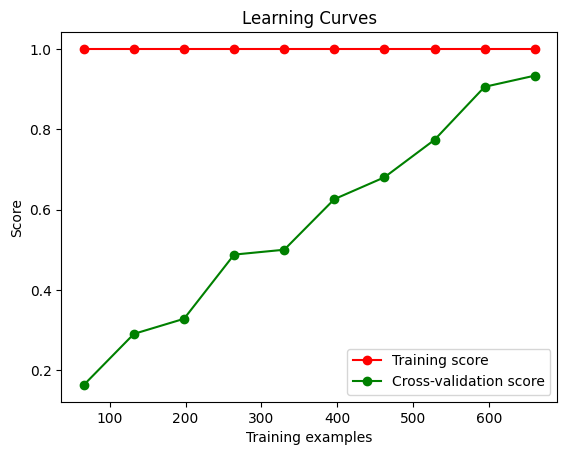

Classification Report:
                 precision    recall  f1-score   support

 Arshdeep_Singh       0.91      0.97      0.94        30
     Axar_Patel       1.00      1.00      1.00        28
 Jasprit_Bumrah       1.00      0.90      0.95        30
  Kuldeep_Yadav       0.97      1.00      0.98        31
Ravindra_Jadeja       0.96      0.96      0.96        24
    Virat_Kohli       1.00      1.00      1.00        23

       accuracy                           0.97       166
      macro avg       0.97      0.97      0.97       166
   weighted avg       0.97      0.97      0.97       166



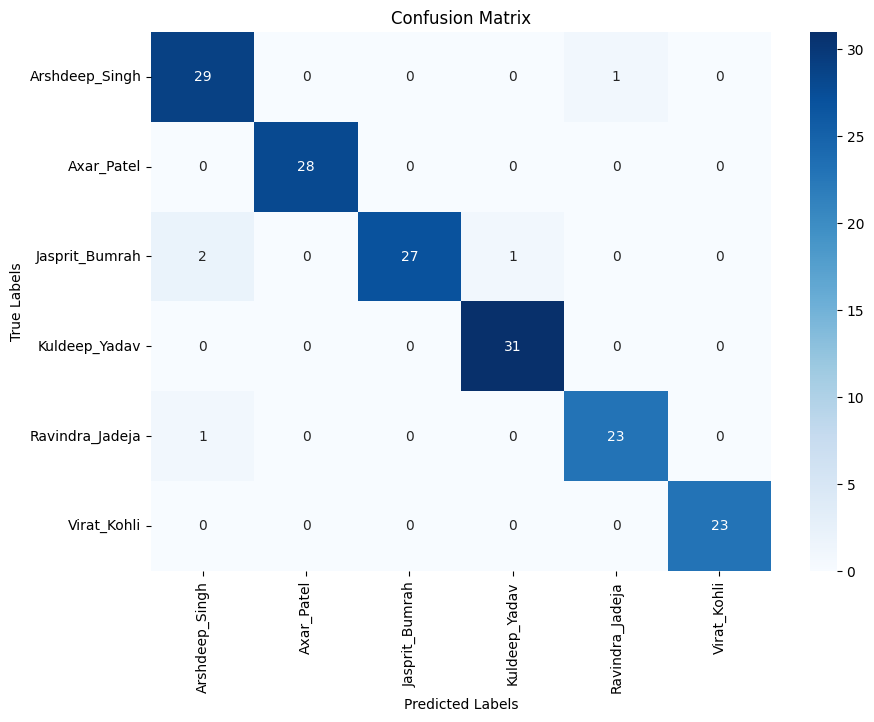

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib

def main():
    # Load YOLO model for detection
    net, output_layers = load_yolo()

    # Load the ResNet model for feature extraction
    model = load_model()
    
    output_frame_folder = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/extracted_frames'
    
    # Load and preprocess data, now passing the model for feature extraction
    X, y, encoder = load_and_preprocess_data(output_frame_folder, net, output_layers, model)

    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Set up the parameter grid
    param_grid = {
        'n_neighbors': range(1, 31, 2),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    # Create a KNeighbors classifier object
    knn = KNeighborsClassifier()

    # Create a GridSearchCV object
    grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', verbose=1)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    # Print out the best parameters and best score
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

    # Retrieve the best model from the grid search
    best_knn = grid_search.best_estimator_
    
    # Evaluate the best model on the training set
    training_accuracy = best_knn.score(X_train, y_train)
    print(f"Training Accuracy: {training_accuracy}")

    # Evaluate the best model on the test set
    test_accuracy = best_knn.score(X_test, y_test)
    print(f"Testing Accuracy: {test_accuracy}")

    # Learning Curves
    train_sizes, train_scores, test_scores = learning_curve(
        best_knn, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(.1, 1.0, 10))
    
    plot_learning_curves(train_sizes, train_scores, test_scores)

    # Generate classification report
    y_pred = best_knn.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=encoder.classes_)
    print("Classification Report:")
    print(report)

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # # Save the best KNN model and label encoder
    # joblib.dump(best_knn, 'best_knn_player_recognition.pkl')
    # joblib.dump(encoder, 'label_encoder.pkl')

def plot_learning_curves(train_sizes, train_scores, test_scores):
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.title("Learning Curves")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.show()

if __name__ == "__main__":
    main()


## Stacking

26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 990ms/step


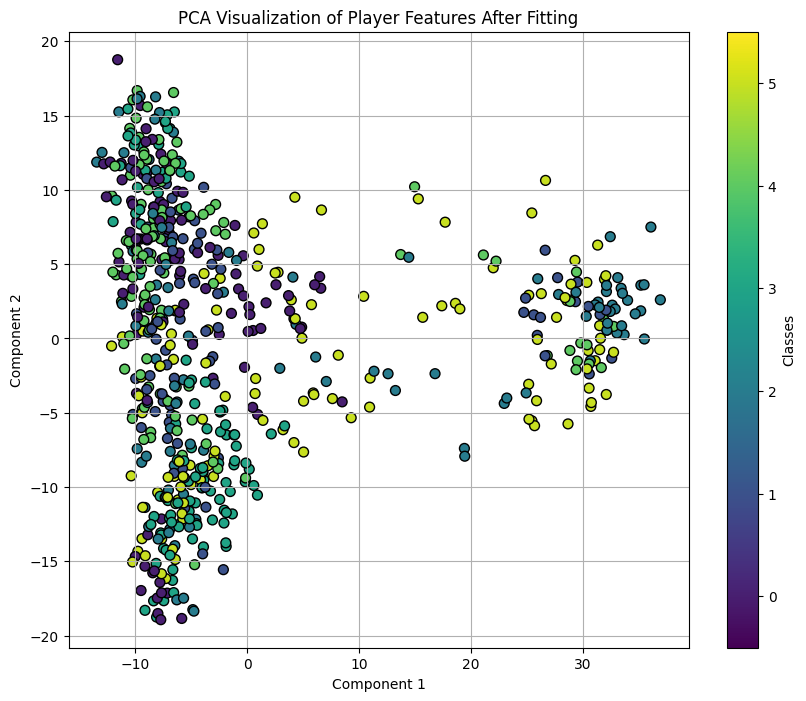

/Users/nadunsenarathne/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


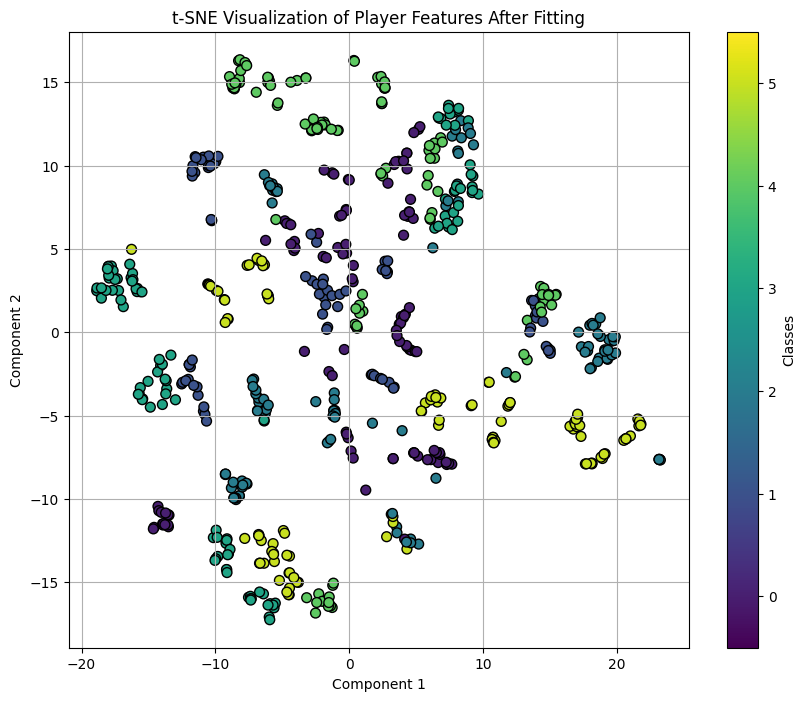

Training Accuracy: 0.9845440494590417
Testing Accuracy: 0.9876543209876543


/Users/nadunsenarathne/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/nadunsenarathne/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/nadunsenarathne/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/nadunsenarathne/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/nadunsenarathne/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least

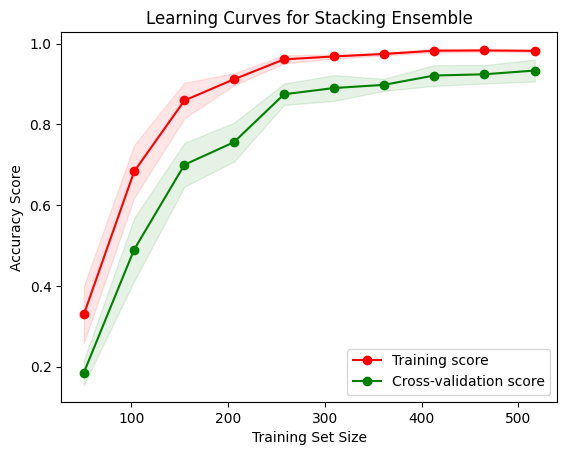

Classification Report:
                 precision    recall  f1-score   support

 Arshdeep_Singh       0.97      1.00      0.98        29
     Axar_Patel       1.00      0.89      0.94        19
 Jasprit_Bumrah       1.00      1.00      1.00        28
  Kuldeep_Yadav       1.00      1.00      1.00        33
Ravindra_Jadeja       0.96      1.00      0.98        26
    Virat_Kohli       1.00      1.00      1.00        27

       accuracy                           0.99       162
      macro avg       0.99      0.98      0.98       162
   weighted avg       0.99      0.99      0.99       162



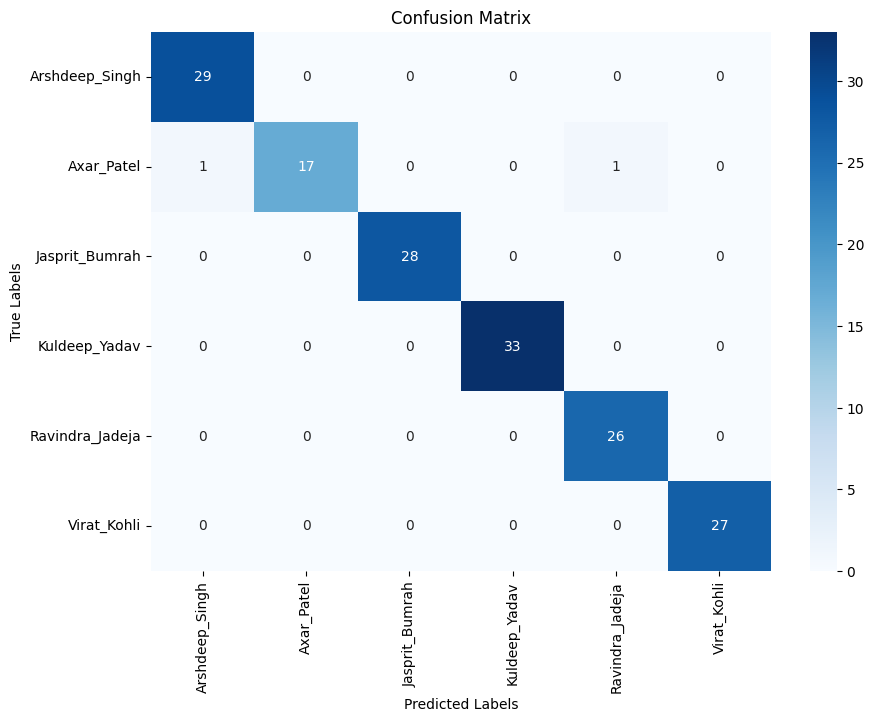

In [30]:
def main():
    # Load YOLO model for detection
    net, output_layers = load_yolo()

    # Load the ResNet model for feature extraction
    model = load_model()

    output_frame_folder = '/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/extracted_frames'

    # Load and preprocess data, passing the model for feature extraction
    X, y, encoder = load_and_preprocess_data(output_frame_folder, net, output_layers, model)

    # Feature selection with ReliefF
    fs = ReliefF(n_neighbors=5, n_features_to_select=1000)  # Adjust parameters as needed
    X = fs.fit_transform(X, y)

    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    

    # Define the base models
    estimators = [
        ('svm', SVC(kernel='rbf', C=1, gamma='scale', probability=True)),
        ('knn', KNeighborsClassifier(n_neighbors=3, metric='manhattan', weights='uniform'))
    ]

    # rf = RandomForestClassifier(n_estimators=100)
    # knn = KNeighborsClassifier(n_neighbors=5, metric='manhattan', weights='uniform')
    log_reg_meta = LogisticRegression(C=0.001, penalty='l2', solver='liblinear')

    # Define the stacking ensemble
    stack = StackingClassifier(estimators=estimators, final_estimator=log_reg_meta)
    stack.fit(X_train, y_train)

    # Make predictions on the training data to see how the model classified the training set
    y_pred_train = stack.predict(X_train)
    # Visualization after fitting
    visualize_with_pca(X_train, y_pred_train, encoder, 'PCA Visualization of Player Features After Fitting')
    visualize_with_tsne(X_train, y_pred_train, encoder, 't-SNE Visualization of Player Features After Fitting')


    # Evaluate the classifier
    train_accuracy = stack.score(X_train, y_train)
    test_accuracy = stack.score(X_test, y_test)
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Testing Accuracy: {test_accuracy}")

    # Plotting the learning curves for the ensemble model
    plot_learning_curves(stack, X_train, y_train, title='Learning Curves for Stacking Ensemble')

    # Generate classification report
    y_pred = stack.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=encoder.classes_)
    print("Classification Report:")
    print(report)

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Save the best ensemble model and label encoder
    joblib.dump(stack, 'ensemble_player_recognition.pkl')
    joblib.dump(encoder, 'ensemble_label_encoder.pkl')

if __name__ == "__main__":
    main()


## Voting Classifier

26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 682ms/step
Training Accuracy: 0.9681818181818181
Testing Accuracy: 0.9578313253012049


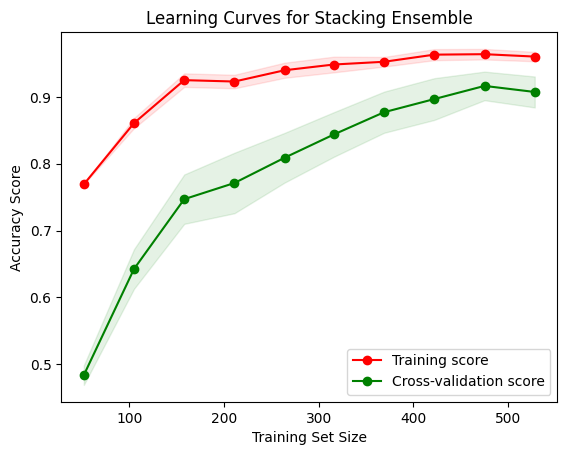

Classification Report:
                 precision    recall  f1-score   support

 Arshdeep_Singh       0.83      1.00      0.91        30
     Axar_Patel       1.00      0.96      0.98        28
 Jasprit_Bumrah       1.00      0.87      0.93        30
  Kuldeep_Yadav       0.97      1.00      0.98        31
Ravindra_Jadeja       1.00      0.92      0.96        24
    Virat_Kohli       1.00      1.00      1.00        23

       accuracy                           0.96       166
      macro avg       0.97      0.96      0.96       166
   weighted avg       0.96      0.96      0.96       166



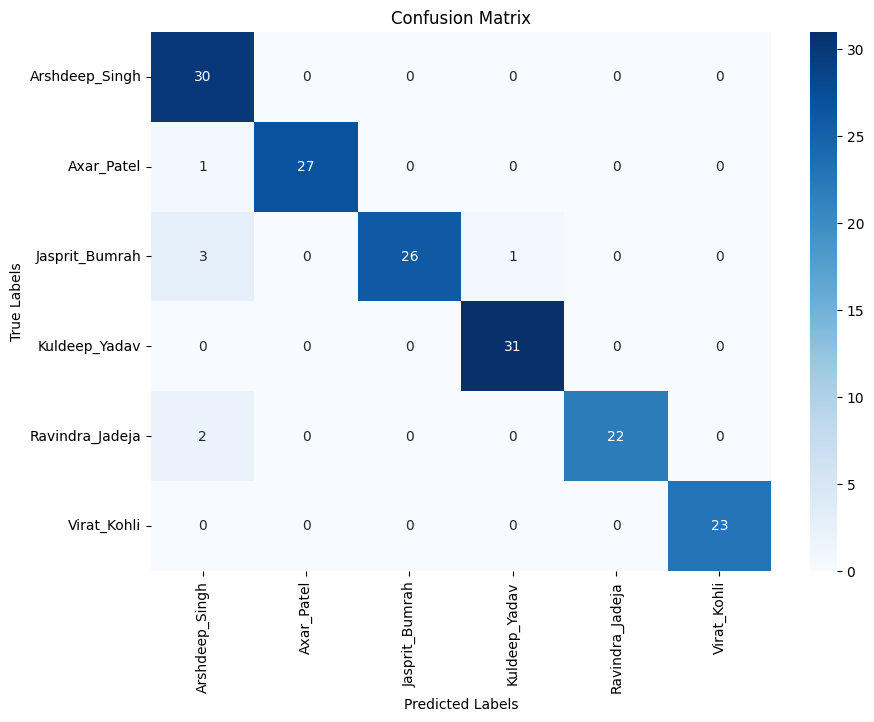

In [59]:
def main():
    # Load YOLO model for detection
    net, output_layers = load_yolo()

    # Load the ResNet model for feature extraction
    model = load_model()

    output_frame_folder = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/extracted_frames'

    # Load and preprocess data, passing the model for feature extraction
    X, y, encoder = load_and_preprocess_data(output_frame_folder, net, output_layers, model)

    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the base models
    estimators = [
        ('svm', SVC(kernel='rbf', C=1, gamma='scale', probability=True)),
        ('knn', KNeighborsClassifier(n_neighbors=3, metric='manhattan', weights='uniform'))
    ]

    # rf = RandomForestClassifier(n_estimators=100)
    # knn = KNeighborsClassifier(n_neighbors=5, metric='manhattan', weights='uniform')
    # log_reg_meta = LogisticRegression(C=0.001, penalty='l2', solver='liblinear')

    # # Define the stacking ensemble
    # stack = StackingClassifier(estimators=estimators, final_estimator=log_reg_meta)
    # stack.fit(X_train, y_train)

    # Define the voting ensemble
    voting_clf = VotingClassifier(estimators=estimators, voting='hard')
    voting_clf.fit(X_train, y_train)

    # Evaluate the classifier
    train_accuracy = voting_clf.score(X_train, y_train)
    test_accuracy = voting_clf.score(X_test, y_test)
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Testing Accuracy: {test_accuracy}")

    # Plotting the learning curves for the ensemble model
    plot_learning_curves(voting_clf, X_train, y_train, title='Learning Curves for Stacking Ensemble')

    # Generate classification report
    y_pred = voting_clf.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=encoder.classes_)
    print("Classification Report:")
    print(report)

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Save the best ensemble model and label encoder
    joblib.dump(voting_clf, 'ensemble_player_recognition.pkl')
    joblib.dump(encoder, 'ensemble_label_encoder.pkl')

if __name__ == "__main__":
    main()


## Decision Level Fusion

26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 669ms/step
Training Accuracy: 0.9681818181818183
Testing Accuracy: 0.9578313253012049
Classification Report:
                 precision    recall  f1-score   support

 Arshdeep_Singh       1.00      1.00      1.00        30
     Axar_Patel       1.00      1.00      1.00        28
 Jasprit_Bumrah       1.00      1.00      1.00        30
  Kuldeep_Yadav       1.00      1.00      1.00        31
Ravindra_Jadeja       1.00      0.96      0.98        24
    Virat_Kohli       0.96      1.00      0.98        23

       accuracy                           0.99       166
      macro avg       0.99      0.99      0.99       166
   weighted avg       0.99      0.99      0.99       166



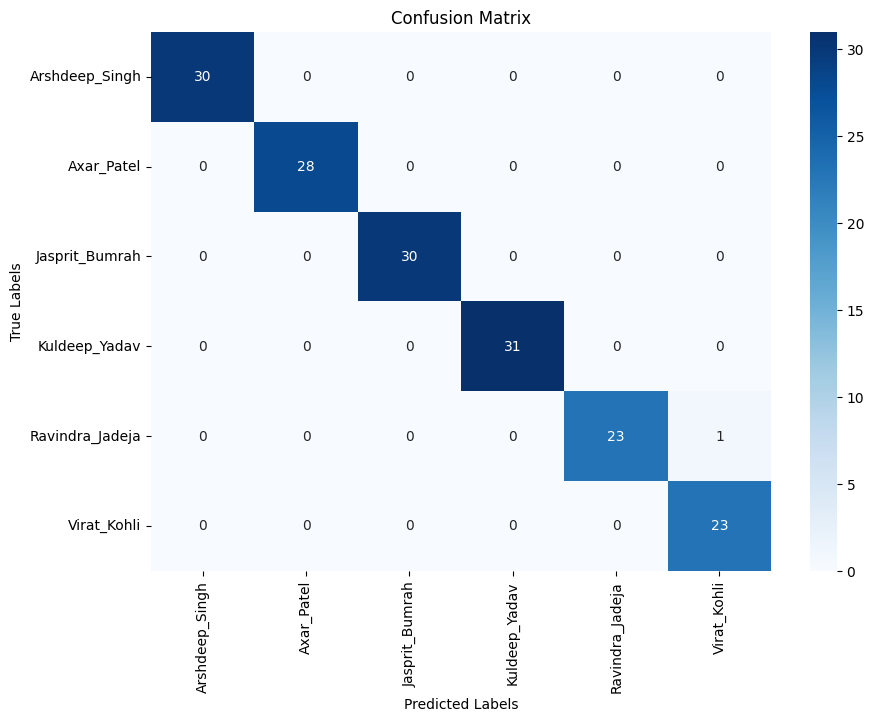

In [60]:
def decision_level_fusion(prob1, prob2):
    """Simple average fusion of probability estimates."""
    return (prob1 + prob2) / 2

def main():
    # Load YOLO model for detection
    net, output_layers = load_yolo()

    # Load the ResNet model for feature extraction
    model = load_model()

    output_frame_folder = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/extracted_frames'

    # Load and preprocess data, passing the model for feature extraction
    X, y, encoder = load_and_preprocess_data(output_frame_folder, net, output_layers, model)

    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    svm = SVC(kernel='rbf', C=1, gamma='scale', probability=True)
    knn = KNeighborsClassifier(n_neighbors=3, metric='manhattan', weights='uniform')

    svm.fit(X_train, y_train)
    knn.fit(X_train, y_train)

    # Get probability predictions
    prob_svm = svm.predict_proba(X_test)
    prob_knn = knn.predict_proba(X_test)

    # Fuse predictions
    fused_prob = decision_level_fusion(prob_svm, prob_knn)
    y_pred = np.argmax(fused_prob, axis=1)  # Convert probabilities to final class prediction

    train_accuracy = (svm.score(X_train, y_train) + knn.score(X_train, y_train)) / 2
    test_accuracy = (svm.score(X_test, y_test) + knn.score(X_test, y_test)) / 2
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Testing Accuracy: {test_accuracy}")

    report = classification_report(y_test, y_pred, target_names=encoder.classes_)
    print("Classification Report:")
    print(report)

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # joblib.dump(svm, 'svm_model.pkl')
    # joblib.dump(knn, 'knn_model.pkl')
    # joblib.dump(encoder, 'label_encoder.pkl')

if __name__ == "__main__":
    main()

## Inference

In [77]:
import cv2
import numpy as np
import os
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image
import joblib

# Load YOLO model and output layers
net, output_layers = load_yolo()
# Load the feature selector


# Function to extract frames from a video
def extract_frames_for_prediction(video_path, net, output_layers, num_frames=10):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    interval = total_frames // num_frames if total_frames > num_frames else 1
    frame_ids = [int(interval * i) for i in range(num_frames)]
    frames = []

    frame_count = 0
    while frame_count < total_frames:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count in frame_ids:
            # Apply YOLO detection to each frame
            boxes, _ = yolo_detect(net, frame, output_layers)
            if boxes:  # Check if there is at least one detection
                x, y, w, h = boxes[0]  # largest detected box 
                cropped_frame = frame[y:y+h, x:x+w]
                frames.append(cropped_frame)
            else:
                print(f"No valid detections at frame {frame_count}.")
        frame_count += 1

    cap.release()
    return frames

# Prediction function adapted for video
def predict_person(video_path, resnet_model, ensemble_model, label_encoder, fs):
    frames = extract_frames_for_prediction(video_path, net, output_layers)
    if not frames:
        return "No frames to analyze or no valid detections."

    # Get features for all frames using the extract_features function
    features = extract_features(frames, resnet_model)

    # Feature selection with ReliefF
    selected_features = fs.transform(features) 

    for feature in selected_features:
        # Ensure each feature is properly reshaped for predict_proba
        probabilities = ensemble_model.predict_proba([feature])[0]
        predicted_class_index = np.argmax(probabilities)
        predicted_player = label_encoder.inverse_transform([predicted_class_index])[0]
        confidence = probabilities[predicted_class_index]
        print(f"Detected person: {predicted_player} with confidence: {confidence:.2f}")
        

# Example usage
video_path = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/test_video/7.mov'
# Load the pre-trained ResNet model
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
# Load trained SVC model and label encoder
ensemble_model = joblib.load('ensemble_player_recognition.pkl')
label_encoder = joblib.load('ensemble_label_encoder.pkl')
fs = joblib.load('relieff_model.pkl')
predict_person(video_path, resnet_model, ensemble_model, label_encoder, fs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step


ValueError: X has 1000 features, but SVC is expecting 2048 features as input.